In [2]:
from model import *
import options
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from dataloader import *

DEVICE = torch.device("cuda")

In [82]:
model = AttriVAE(image_channels=3, hidden_dim=100, latent_dim=32, encoder_channels=(8, 16, 32, 64, 4), decoder_channels=(64, 32, 16, 8, 4, 4)).to(DEVICE)
cp = torch.load("saves_old/[2024-04-21 03:33:57]-STATE-AttriVAE-e200.pt")
model.load_state_dict(cp)
model.eval()

AttriVAE(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(64, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running

In [84]:
model = MoreAttriVAE(image_channels=options.IMG_CHANNELS, hidden_dim=options.HIDDEN_DIM, latent_dim=options.LATENT_DIM, encoder_channels=options.ENCODER_CHANNELS, decoder_channels=options.DECODER_CHANNELS).to(DEVICE)
cp = torch.load("saves/[2024-04-21 23:53:24]-STATE-MoreAttriVAE-e200.pt")
model.load_state_dict(cp['model_state'])
model.eval()

MoreAttriVAE(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine

In [11]:
import os


def show_image(img):
    """
    Function that displays an input tensor, which may contain multiple images,
    using pyplot.

    Args:
        img (Tensor): Input tensor which contains a grid of images, e.g. as
                      output by torch.utils.make_grid

    """
    plt.imshow(img.cpu().numpy().transpose(1,2,0))
    plt.axis('off')
    
def visualise_output(images, model):
    """
    Function that takes an input Tensor of images, passes the first 50 through
    a trained input VAE model (encoder and decoder) and then displays the
    reconstructed images in a 5x10 grid.

    Args:
        images (Tensor): Input tensor of images
        model (Torch model): trained VAE model

    # """

    images_50 = images[:50]

    with torch.no_grad():
      x_recon, mu, logvar, z_tilde, z_dist, prior_dist = model.forward(images_50)

      # displaying images
      images_to_display = make_grid(x_recon.view(16, 3, 128, 128), nrow = 8)
      show_image(images_to_display)

In [8]:
import pickle
with open(options.FEATURES_DF_PKL_FILEPATH, 'rb') as file:
    features_df = pickle.load(file)
train_loader = get_dataloader(options.IMG_PROCESSED_DIRPATH, options.IMGLIST_PROCESSED_FILEPATH, features_df)

In [80]:
images, labels = next(iter(train_loader))
images = images.to(DEVICE)

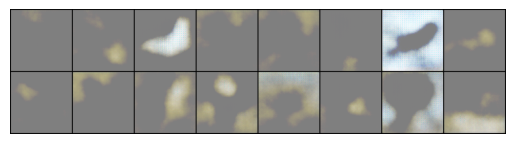

In [85]:
visualise_output(images, model)

### Bird Hybrid

In [35]:
uniquebirds = []
with open('images-processed.txt', 'r') as file:
    # Read each line in the file
    for line in file:
        line = line.strip()
        lines = line.split("/")[0]
        bird = lines.split(".")[1]
        if bird not in uniquebirds:
            uniquebirds.append(bird)

for bird in range(len(uniquebirds)):
    uniquebirds[bird] = uniquebirds[bird].replace('_', ' ')

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
import pickle
import os
import sys
import wandb
import argparse
# from torchsummary import summary

from loss import *
from model import *
from dataloader import *
from utils import *
import options

with open(options.FEATURES_DF_PKL_FILEPATH, 'rb') as file:
    features_df = pickle.load(file)

In [49]:
print(features_df.iloc[639])

has_bill_shape          0.888889
has_wing_color          0.933333
has_upperparts_color    0.933333
has_underparts_color    0.933333
has_breast_pattern      0.250000
has_back_color          0.933333
has_tail_shape          0.666667
has_upper_tail_color    0.933333
has_head_pattern        0.818182
has_breast_color        0.933333
has_throat_color        0.933333
has_eye_color           0.000000
has_bill_length         1.000000
has_forehead_color      0.933333
has_under_tail_color    0.933333
has_nape_color          0.933333
has_belly_color         0.933333
has_wing_shape          0.000000
has_size                1.000000
has_shape               1.000000
has_back_pattern        0.250000
has_tail_pattern        0.250000
has_belly_pattern       0.250000
has_primary_color       0.933333
has_leg_color           0.400000
has_bill_color          0.933333
has_crown_color         0.933333
has_wing_pattern        1.000000
Name: 639, dtype: float64


In [74]:
def translate(row):
    bird_string = "I am going to describe a new bird with the different features it has."
    with open("featuremap.pkl", 'rb') as file:
        featuremap = pickle.load(file)
    
    for column_name, cell_value in row.items():
        if cell_value != 0:
            attr = featuremap[(featuremap['Attribute'] == column_name) & (featuremap['Attribute Value'] == cell_value)]
            attr = attr['Val'].iloc[0]
    
            attribute = column_name.replace("_", " ")
            identifier = attribute.split(" ")[1:]
            
            identifier = ' '.join(identifier)
            sentence = f" This bird has a {identifier} of: {attr}"  
            bird_string += sentence
    return bird_string

In [86]:
translate(features_df.iloc[639])

'I am going to describe a new bird with the different features it has. This bird has a bill shape of: cone This bird has a wing color of: red This bird has a upperparts color of: red This bird has a underparts color of: red This bird has a breast pattern of: solid This bird has a back color of: red This bird has a tail shape of: fan-shaped_tail This bird has a upper tail color of: red This bird has a head pattern of: eyeline This bird has a breast color of: red This bird has a throat color of: red This bird has a bill length of: shorter_than_head This bird has a forehead color of: red This bird has a under tail color of: red This bird has a nape color of: red This bird has a belly color of: red This bird has a size of: very_small_(3_-_5_in) This bird has a shape of: perching-like This bird has a back pattern of: solid This bird has a tail pattern of: solid This bird has a belly pattern of: solid This bird has a primary color of: red This bird has a leg color of: grey This bird has a bi

In [77]:
import random
env = {0: "desert", 1: "tundra", 2: "rainforest"}
random_number = random.randint(0, 2)

birdies = [0, 527, 639]

print(f"I will give you {len(birdies)} birds and features they have and I want you to tell me which two are most likely to survive in a {env[random_number]}.\n")
for b in birdies:
    print(f"{translate(features_df.iloc[b])}\n")

I will give you 3 birds and features they have and I want you to tell me which two are most likely to survive in a desert.

I am going to describe a new bird with the different features it has. This bird has a wing color of: grey This bird has a upperparts color of: grey This bird has a underparts color of: white This bird has a back color of: grey This bird has a tail shape of: notched_tail This bird has a upper tail color of: grey This bird has a head pattern of: striped This bird has a breast color of: white This bird has a throat color of: red This bird has a eye color of: black This bird has a bill length of: shorter_than_head This bird has a forehead color of: red This bird has a under tail color of: grey This bird has a nape color of: grey This bird has a belly color of: white This bird has a wing shape of: rounded-wings This bird has a size of: small_(5_-_9_in) This bird has a shape of: perching-like This bird has a primary color of: grey This bird has a leg color of: brown Thi